# Vorticity Budget in CM4X-p25 and CM4X-p125

Barotropic vorticity budget (climatological-mean) is compared in GFDL CM4X-p25 and CM4X-p125 pre-industrial control simulations. The budget analysis is used to investigate how representation of bathymetry and mesoscale eddies affect gyre transports in the North Atlantic Ocean. The steady-state barotropic vorticity budget is 

\begin{equation}
\beta \, V \approx \frac{1}{\rho_o}J(p_b,H) + \frac{\nabla \wedge \tau_s}{\rho_o} + \nabla \wedge \mathcal{A} + \mbox{Addtl terms}
\end{equation}

Here, $V$ is depth-integrated meridional velocity, $J(p_b,H)$ is bottom pressure torque, $\tau_s$ is the surface wind stress and $\mathcal{A}$ is the depth-integrated nonlinear advectiont term. 

Vorticity budget terms exhibit strong spatial variability and can be very noisy. To compare budget terms, we rewrite the above equation in streamfunction form (integrate along the zonal direction, $\psi$ represents the barotropic streamfunction, see mode details in Yeager (2015), JPO),

\begin{equation}
\psi = \int_{x_w}^{x}V \mathrm{d}x = \underbrace{\frac{1}{\beta\rho_o}\int_{x_w}^{x}J(p_b,H)\mathrm{d}x}_{\psi_{BPT}} + \underbrace{\int_{x_w}^{x}\frac{\nabla \wedge \tau_s}{\beta \rho_o}\mathrm{d}x}_{\psi_{\tau_s}} + \underbrace{\int_{x_w}^{x}\frac{\nabla \wedge \mathcal{A}}{\beta}\mathrm{d}x}_{\psi_{\mathcal{A}}} + \mbox{...}
\end{equation}

Streamfunctions corresponding to different terms are analysed to undertand their roles in driving the gyre transport. We use GCM-Filters package to spatilly smooth streamfunction maps to $10^{\circ}$ resolution to remove small-scale variability and grid noise.


In [1]:
import xarray as xr
import xesmf as xe
from xgcm import Grid
import numpy as np
import regionmask
from xmip.regionmask import merged_mask
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gcm_filters

In [2]:
# Read barotropic vorticity budget data on native grid

ds_p25 = xr.open_dataset("../../../Data/Data_CM4_GFDL/CM4X_datashare/CM4X_p25_Vorticity_Budget.nc")
ds_p125 = xr.open_dataset("../../../Data/Data_CM4_GFDL/CM4X_datashare/CM4X_p125_Vorticity_Budget.nc")

In [3]:
# plotting function

def plot_sec(ax, da, vmin=-999, vmax=999, vstep=1, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?', aspect_rt = 1.0,
             add_left_lables = True):
    
    contours = np.arange(vmin, vmax+vstep, vstep)
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    #cb = plt.colorbar(p, ax=ax, extend='both', orientation="horizontal", shrink=0.6)
    #cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    #ax.coastlines()
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = add_left_lables
    gl.ylocator = mticker.FixedLocator(np.arange(-90,81,30))
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180,30))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
        
    ax.set_aspect(aspect_rt)
    
    _ = plt.title(title, fontsize=14)
    return p

## Streamfunctions

Compute cumsum of vorticity budget terms in the zonal direction to obtain the streamfunction forms.

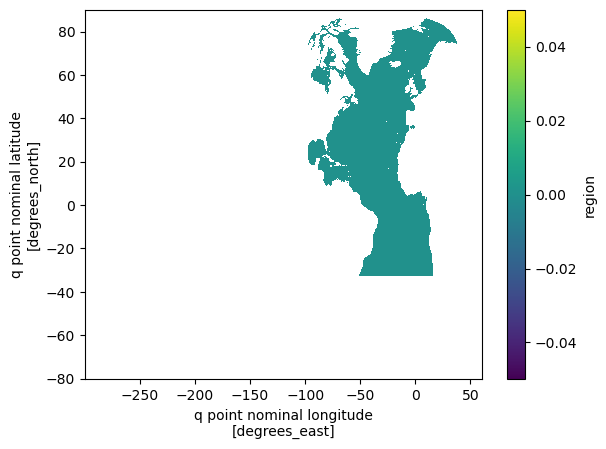

In [4]:
# Create North Atlantic Mask
ds = ds_p25

ds['mask'] = ds['wet_c']

# Create North Atlantic Mask
North_Atl = np.array([[-100., 40., 40., 20., 8., 11., -6, 16, 15., -65., -75., -79., 
                       -81., -82., -89., -100., -100., -75., -75., -100., -100.], 
                     [80., 80., 68., 68., 60., 50., 40., 20., -33., -33., 6., 9.2, 
                      8.5, 8.5, 15., 20., 40., 40., 50., 50., 80.]]).transpose()

names = ["North Atlantic"]; abbrevs = ["NA"]

Ocean_Regions = regionmask.Regions([North_Atl], names=names, abbrevs=abbrevs, 
                                        name="Subpolar North Atlantic")

mask_NAtl = Ocean_Regions.mask(ds['geolon_c'], ds['geolat_c'])
mask_NAtl = mask_NAtl.where(ds['mask']>0.)

mask_NAtl.plot()

In [6]:
%%time

OMEGA = 7.2921e-5
RAD_EARTH = 6.378e6

psi = []
psi_rev = []
ds_list = [ds_p25, ds_p125]

var_list = ['beta_V', 'BPT', 'Curl_Adv', 'Curl_taus', 'Curl_taub', 
            'Curl_diff', 'Mass_flux', 'Curl_dudt', 'eta_dt']

i = 0
for ds in ds_list:

    beta = 2*OMEGA*np.cos(ds['geolat_c'] * np.pi /180.)/RAD_EARTH

    grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                            'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X'])

    ds['dx_c'] = grid.interp(ds['dxCv'], 'X',  boundary='fill')

    # Create land mask for North Atlantic
    ds['mask'] = ds['wet_c']

    # Create North Atlantic Mask
    North_Atl = np.array([[-100., 40., 40., 20., 8., 11., -6, 16, 15., -65., -75., -79., 
                       -81., -82., -89., -100., -100., -75., -75., -100., -100.], 
                     [80., 80., 68., 68., 60., 50., 40., 20., -33., -33., 6., 9.2, 
                      8.5, 8.5, 15., 20., 40., 40., 50., 50., 80.]]).transpose()

    names = ["North Atlantic"]; abbrevs = ["NA"]

    Ocean_Regions = regionmask.Regions([North_Atl], names=names, abbrevs=abbrevs, 
                                         name="Subpolar North Atlantic")

    mask_NAtl = Ocean_Regions.mask(ds['geolon_c'], ds['geolat_c'])
    mask_NAtl = mask_NAtl.where(ds['mask']>0.)

    # Compute streamfunction (in Sv) from vorticity budget terms
    psi_tmp = (ds.get(var_list) * ds['dx_c'].where(mask_NAtl == 0.) / beta).cumsum('xq') / 1.e6

    psi_tmp = psi_tmp.where(mask_NAtl == 0.)
    psi_tmp['mask'] = xr.where(mask_NAtl == 0., 1, 0)

    psi.append(psi_tmp)

    # Compute streamfunction (in Sv) from vorticity budget terms (inegrate from east to west)
    ds_rev = ds.get(var_list) * ds['dx_c'].where(mask_NAtl == 0.) / beta
    ds_rev = ds_rev.isel(xq=slice(None, None, -1))
    psi_tmp = ds_rev.cumsum('xq') / 1.e6
    psi_tmp = psi_tmp.isel(xq=slice(None, None, -1))

    psi_tmp = psi_tmp.where(mask_NAtl == 0.)
    psi_tmp['mask'] = xr.where(mask_NAtl == 0., 1, 0)

    psi_rev.append(psi_tmp)
    
    i = i + 1

CPU times: user 4.93 s, sys: 1.16 s, total: 6.09 s
Wall time: 6.1 s


In [7]:
## Use gcm-filters to spatially smooth the data

dx_min = 1
filter_shape = gcm_filters.FilterShape.GAUSSIAN

ds_list = psi
ds_filter_factor = []

for i in range(0, len(ds_list)):
    
    wet_mask = ds_list[i]['mask']
    
    if(i==0):
        factor = 40 # to 10 deg
        area = ds_p25['areacello_bu']
    else:
        factor = 80 # to 10 deg
        area = ds_p125['areacello_bu']
    
    filter_tripolar_regular_with_land = gcm_filters.Filter(filter_scale=factor, dx_min=1,
                                                           filter_shape=filter_shape, 
                                                           grid_type=gcm_filters.GridType.TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED,
                                                           grid_vars={'area': area, 'wet_mask': wet_mask})
    ds1 = ds_list[i]
    %time ds_smooth = filter_tripolar_regular_with_land.apply(ds1, dims=['yq', 'xq'])
    ds_filter_factor.append(ds_smooth)
    

CPU times: user 8.7 s, sys: 5.12 s, total: 13.8 s
Wall time: 13.8 s
CPU times: user 1min 11s, sys: 42.5 s, total: 1min 53s
Wall time: 1min 53s


CM4X-p25 model
Psi max =  24.82963596738253 , Lat-Lon =  32.69157857677035 ,  -70.26816205730927
Psi min =  -43.70553217857332 , Lat-Lon =  58.42319568253727 ,  -52.06899369643079
Psi-BPT max =  25.361885535635924 Psi-Tau max =  -1.4898812008600288 Psi-A max =  -0.6973237752440665
Psi-BPT min =  -38.122003803892085 Psi-Tau min =  0.1978025849071203 Psi-A min =  3.6178277770174274
 
CM4X-p125 model
Psi max =  30.314768744522638 , Lat-Lon =  31.046240851079144 ,  -68.7617973334067
Psi min =  -37.34221479217367 , Lat-Lon =  57.72918347390023 ,  -43.99650498342176
Psi-BPT max =  29.729825992634083 Psi-Tau max =  -2.387022085448836 Psi-A max =  2.0066800715498267
Psi-BPT min =  -33.34764605403735 Psi-Tau min =  -0.15885075306956806 Psi-A min =  1.4849754547782734
 


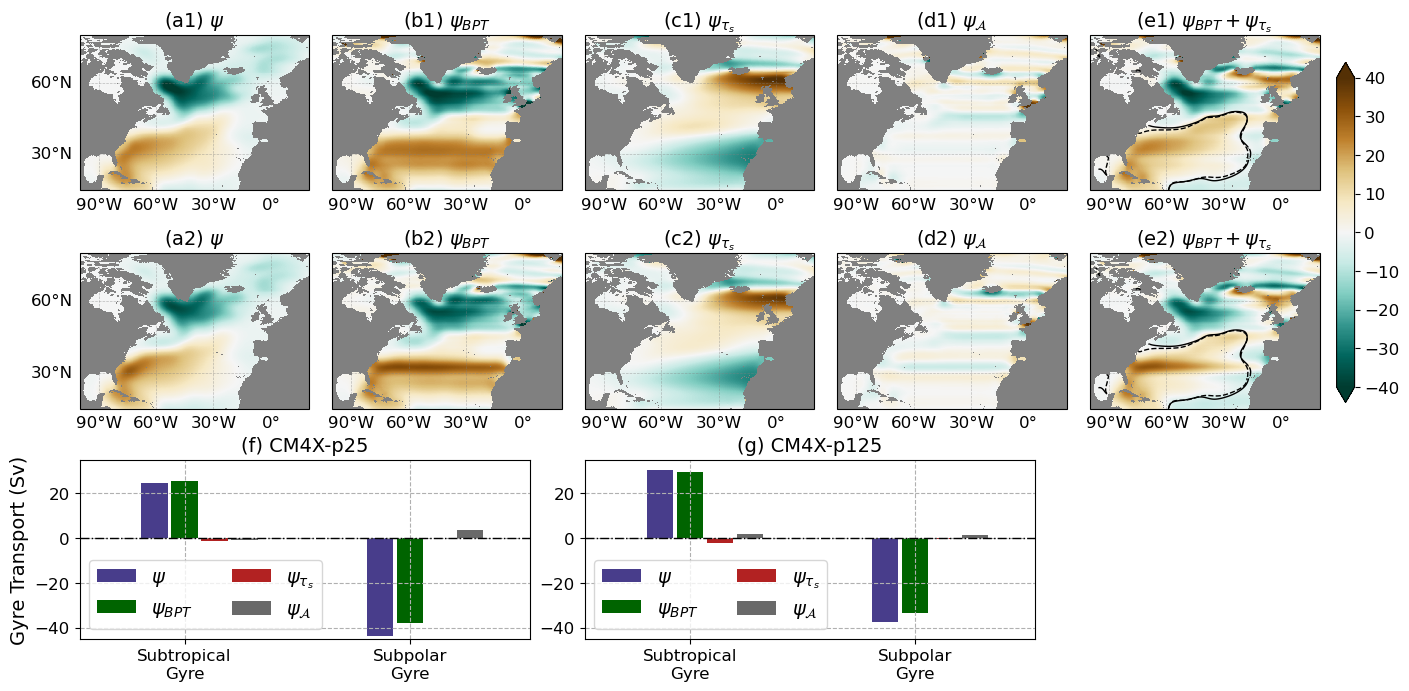

In [12]:
## Plot 

# This plot was included in the original submission and it was eventually removed
# at the revision stage due to concern related excessive spatial smoothing
# and its effect on gyre transport magnitudes and their locations.

lat_lon_ext = [-100., 20., 15., 80.]

var_list = ['beta_V', 'BPT', 'Curl_taus', 'Curl_Adv']
title_list = [r'$\psi$', r'$\psi_{BPT}$', r'$\psi_{\tau_s}$', r'$\psi_{\mathcal{A}}$',
              r'$\psi_{BPT} + \psi_{\tau_s}$']
ds_list = ds_filter_factor
max_r = 40.

grid1 = plt.GridSpec(3, 5, wspace=0.1, hspace=0.22)
fig = plt.figure(figsize=[16,8])

for i in range(0, len(ds_list)):
    if(i==0):
        print("CM4X-p25 model")
    else:
        print("CM4X-p125 model")
        
    for j in range(0, len(var_list)+1):
        ax = fig.add_subplot(grid1[i, j],projection=ccrs.PlateCarree(),facecolor='grey')

        if(j==4):
            tmp = ds_list[i]['BPT'] + ds_list[i]['Curl_taus']
        else:
            tmp = ds_list[i][var_list[j]]

        if(i==0):
            tmp = tmp.drop(['geolon_c', 'geolat_c'])
            tmp = tmp.assign_coords({'geolon_c': ds_p25['geolon_c'], 
                                      'geolat_c': ds_p25['geolat_c']})
        else:
            tmp = tmp.drop(['geolon_c', 'geolat_c'])
            tmp = tmp.assign_coords({'geolon_c': ds_p125['geolon_c'], 
                                      'geolat_c': ds_p125['geolat_c']})

        if(j==0):
            left_lables=True
        else:
            left_lables=False
            
        p = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                     lat_lon_ext = lat_lon_ext, lon='geolon_c', lat='geolat_c', cmap='BrBG_r', 
                     add_left_lables = left_lables, aspect_rt = 1.25,
                     title='(' + chr(97+j) + str(i+1) + ') ' + title_list[j])
        
        if(j==4):
            tmp = ds_list[0]['beta_V'] # psi[0]['beta_V']
            CS = ax.contour(tmp['geolon_c'], tmp['geolat_c'], tmp.where(ds_list[0]['mask'] > 0.5), [0], 
                            linewidths=1., colors='black')
            
            tmp = ds_list[1]['beta_V'] # psi[0]['beta_V']
            CS = ax.contour(tmp['geolon_c'], tmp['geolat_c'], tmp.where(ds_list[1]['mask'] > 0.5), [0], 
                            linewidths=1., linestyles='--', colors='black')
            #ax.clabel(CS, inline=False, fontsize=12)
        
        if(j==0):
            psi_max = (tmp).where(tmp==tmp.max(), drop=True).squeeze() #tmp.max().values
            psi_min = (tmp).where(tmp==tmp.min(), drop=True).squeeze()
            
            print("Psi max = ", psi_max.values, ", Lat-Lon = ", psi_max['yq'].values, ", ", psi_max['xq'].values)
            print("Psi min = ", psi_min.values, ", Lat-Lon = ", psi_min['yq'].values, ", ", psi_min['xq'].values)

        ax1 = ax
        
        if(j==4):
            ax = fig.add_subplot(grid1[2, 2*i:2+2*i])
            plt.bar(2., psi_max.values, 0.35, bottom=0., color ='darkslateblue', label = title_list[0])
            plt.bar(2.4, ds_list[i]['BPT'].sel(xq=psi_max['xq'], yq=psi_max['yq']).values, 
                    0.35, bottom=0., color ='darkgreen', label = title_list[1])
            plt.bar(2.8, ds_list[i]['Curl_taus'].sel(xq=psi_max['xq'], yq=psi_max['yq']).values, 
                    0.35, bottom=0., color ='firebrick', label = title_list[2])
            plt.bar(3.2, ds_list[i]['Curl_Adv'].sel(xq=psi_max['xq'], yq=psi_max['yq']).values, 
                    0.35, bottom=0., color ='dimgray', label = title_list[3])
            
            plt.bar(5., psi_min.values, 0.35, bottom=0., color ='darkslateblue')
            plt.bar(5.4, ds_list[i]['BPT'].sel(xq=psi_min['xq'], yq=psi_min['yq']).values, 
                    0.35, bottom=0., color ='darkgreen')
            plt.bar(5.8, ds_list[i]['Curl_taus'].sel(xq=psi_min['xq'], yq=psi_min['yq']).values, 
                    0.35, bottom=0., color ='firebrick')
            plt.bar(6.2, ds_list[i]['Curl_Adv'].sel(xq=psi_min['xq'], yq=psi_min['yq']).values, 
                    0.35, bottom=0., color ='dimgray')
            
            print("Psi-BPT max = ", ds_list[i]['BPT'].sel(xq=psi_max['xq'], yq=psi_max['yq']).values,
                  "Psi-Tau max = ", ds_list[i]['Curl_taus'].sel(xq=psi_max['xq'], yq=psi_max['yq']).values,
                  "Psi-A max = ", ds_list[i]['Curl_Adv'].sel(xq=psi_max['xq'], yq=psi_max['yq']).values)
            print("Psi-BPT min = ", ds_list[i]['BPT'].sel(xq=psi_min['xq'], yq=psi_min['yq']).values,
                  "Psi-Tau min = ", ds_list[i]['Curl_taus'].sel(xq=psi_min['xq'], yq=psi_min['yq']).values,
                  "Psi-A min = ", ds_list[i]['Curl_Adv'].sel(xq=psi_min['xq'], yq=psi_min['yq']).values)
            print(" ")
        
            if(i==0):
                ax.set_ylabel('Gyre Transport (Sv)', fontsize =14)
                ax.set_title('(f) CM4X-p25', fontsize =14)
            else:
                ax.set_title('(g) CM4X-p125', fontsize =14)
            plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
            plt.xticks([2.4, 5.4], ['Subtropical' + '\n' + 'Gyre', 'Subpolar' + '\n' + 'Gyre'], fontsize=12);
            ax.grid(ls='--')
            ax.axhline(y=0., ls='-.', lw=1., color='k');
            ax.set_xlim([1., 7.])
            ax.set_ylim([-45., 35.])
            
            ax.legend(loc='center left', ncol=2,  bbox_to_anchor=(.0, 0.25), fontsize=14)

            bbox=plt.gca().get_position()
            
            offset=.02
            plt.gca().set_position([bbox.x0, bbox.y0, bbox.x1 - bbox.x0 - 
                                    offset, bbox.y1 - bbox.y0 + 0.0*offset])

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

axins = inset_axes(ax, width="2%",  # width = 5% of parent_bbox width
                   height="95%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(1.67, 1.32, 2., 2.),
                   bbox_transform=ax.transAxes,
                   borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both') #, orientation="horizontal")
cb.ax.tick_params(labelsize=12)

fig.savefig('./Atlantic_Vorticity_Budget.png',dpi=300,bbox_inches='tight');


In [7]:
## Use gcm-filters to spatially smooth the data

dx_min = 1
filter_shape = gcm_filters.FilterShape.GAUSSIAN

ds_list = psi_rev
ds_filter_factor = []

for i in range(0, len(ds_list)):
    
    wet_mask = ds_list[i]['mask']
    
    if(i==0):
        factor = 4 # to 1 deg
        area = ds_p25['areacello_bu']
    else:
        factor = 8 # to 1 deg
        area = ds_p125['areacello_bu']
    
    filter_tripolar_regular_with_land = gcm_filters.Filter(filter_scale=factor, dx_min=1,
                                                           filter_shape=filter_shape, 
                                                           grid_type=gcm_filters.GridType.TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED,
                                                           grid_vars={'area': area, 'wet_mask': wet_mask})
    ds1 = ds_list[i]
    %time ds_smooth = filter_tripolar_regular_with_land.apply(ds1, dims=['yq', 'xq'])
    ds_filter_factor.append(ds_smooth)

    

CPU times: user 1.08 s, sys: 687 ms, total: 1.77 s
Wall time: 1.77 s
CPU times: user 7.99 s, sys: 4.99 s, total: 13 s
Wall time: 13.1 s


In [9]:
def plot_sec(ax, da, vmin=-999, vmax=999, levels=10, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?', aspect_rt = 1.0,
             add_left_lables = True):
    
    #contours = np.arange(vmin, vmax+vstep, vstep)
    
    p = da.plot.contourf(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, levels= levels, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False, extend='both')
    
    # add separate colorbar
    #cb = plt.colorbar(p, ax=ax, extend='both', orientation="horizontal", shrink=0.6)
    #cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    #ax.coastlines()
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = add_left_lables
    gl.ylocator = mticker.FixedLocator(np.arange(-90,81,30))
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180,30))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
        
    ax.set_aspect(aspect_rt)
    
    _ = plt.title(title, fontsize=14)
    return p

 
CM4X-p25 model
Psi max =  49.75867940106855 , Lat-Lon =  59.708156743548265 ,  -54.33820178480655
Psi min =  -69.20129863303703 , Lat-Lon =  34.975601418342954 ,  -71.5355469134216
Psi-Tau max =  30.43463110137725
Psi-Tau min =  -22.283603872560356
 
CM4X-p125 model
Psi max =  42.07412744434422 , Lat-Lon =  59.86541242819234 ,  -48.93070341295985
Psi min =  -69.18479804940868 , Lat-Lon =  31.89911629564273 ,  -69.47588018209215
Psi-Tau max =  32.36416138382636
Psi-Tau min =  -25.336173630778585


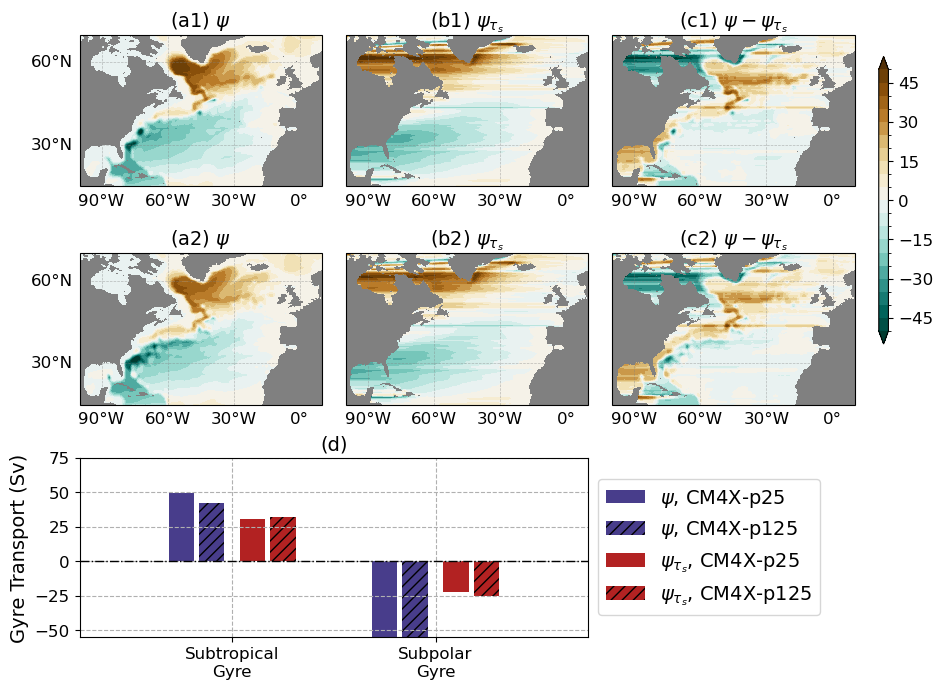

In [10]:
## Plot 

# This figure is used in the final manuscript. It uses nomail spatial smoothing at 1 Deg resolution.
# With 1 deg filter, decomposition into bottom pressure torque and nonlinear advection signals is not viable
# as small-scale noise is not completely removed.

lat_lon_ext = [-100., 10., 15., 70.]

var_list = ['beta_V', 'Curl_taus']
title_list = [r'$\psi$', r'$\psi_{\tau_s}$', r'$\psi - \psi_{\tau_s}$']

max_r = 50.

ds_list = ds_filter_factor
for j in range(0, len(var_list)):
    ds_list[0][var_list[j]] = ds_list[0][var_list[j]] * (-1.) # run this cell twice
    ds_list[1][var_list[j]] = ds_list[1][var_list[j]] * (-1.) # data may not change with one run

grid1 = plt.GridSpec(3, 3, wspace=0.1, hspace=0.22)
fig = plt.figure(figsize=[10,8])

psi_max_all = []
psi_min_all = []

for i in range(0, len(ds_list)):
    if(i==0):
        print(" ")
        print("CM4X-p25 model")
    else:
        print(" ")
        print("CM4X-p125 model")

    for j in range(0, len(var_list)+1):
        ax = fig.add_subplot(grid1[i, j],projection=ccrs.PlateCarree(),facecolor='grey')

        if(j==2):
            tmp = ds_list[i]['beta_V'] - ds_list[i]['Curl_taus']
        else:
            tmp = ds_list[i][var_list[j]]

        if(i==0):
            tmp = tmp.drop(['geolon_c', 'geolat_c'])
            tmp = tmp.assign_coords({'geolon_c': ds_p25['geolon_c'], 
                                      'geolat_c': ds_p25['geolat_c']})
        else:
            tmp = tmp.drop(['geolon_c', 'geolat_c'])
            tmp = tmp.assign_coords({'geolon_c': ds_p125['geolon_c'], 
                                      'geolat_c': ds_p125['geolat_c']})

        if(j==0):
            left_lables=True
        else:
            left_lables=False
            
        p = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, levels = 21, 
                     lat_lon_ext = lat_lon_ext, lon='geolon_c', lat='geolat_c', cmap='BrBG_r', 
                     add_left_lables = left_lables, aspect_rt = 1.25,
                     title='(' + chr(97+j) + str(i+1) + ') ' + title_list[j])
        
        if(j==0):
            psi_max = (tmp).where(tmp==tmp.max(), drop=True).squeeze() #tmp.max().values
            psi_min = (tmp).where(tmp==tmp.min(), drop=True).squeeze()

            psi_max_all.append(psi_max)
            psi_min_all.append(psi_min)
            
            print("Psi max = ", psi_max.values, ", Lat-Lon = ", psi_max['yq'].values, ", ", psi_max['xq'].values)
            print("Psi min = ", psi_min.values, ", Lat-Lon = ", psi_min['yq'].values, ", ", psi_min['xq'].values)

        elif(j == 1):
            print("Psi-Tau max = ", ds_list[i]['Curl_taus'].sel(xq=psi_max['xq'], yq=psi_max['yq']).values)
            print("Psi-Tau min = ", ds_list[i]['Curl_taus'].sel(xq=psi_min['xq'], yq=psi_min['yq']).values)

        ax1 = ax

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

axins = inset_axes(ax, width="2%",  # width = 5% of parent_bbox width
                   height="95%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(1.1, 0.4, 2., 2.),
                   bbox_transform=ax.transAxes,
                   borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both') #, orientation="horizontal")
cb.ax.tick_params(labelsize=12)

ax = fig.add_subplot(grid1[2, 0:2])

plt.bar(2., psi_max_all[0].values, 0.25, bottom=0., color ='darkslateblue', label = title_list[0] + ', CM4X-p25')
plt.bar(2.3, psi_max_all[1].values, 0.25, bottom=0., color ='darkslateblue', label = title_list[0] + ', CM4X-p125', hatch='///')

plt.bar(2.7, ds_list[0]['Curl_taus'].sel(xq=psi_max_all[0]['xq'], yq=psi_max_all[0]['yq']).values, 
                    0.25, bottom=0., color ='firebrick', label = title_list[1] + ', CM4X-p25')
plt.bar(3.0, ds_list[1]['Curl_taus'].sel(xq=psi_max_all[1]['xq'], yq=psi_max_all[1]['yq']).values, 
                    0.25, bottom=0., color ='firebrick', label = title_list[1] + ', CM4X-p125', hatch='///')
            
plt.bar(4., psi_min_all[0].values, 0.25, bottom=0., color ='darkslateblue')
plt.bar(4.3, psi_min_all[1].values, 0.25, bottom=0., color ='darkslateblue', hatch='///')

plt.bar(4.7, ds_list[0]['Curl_taus'].sel(xq=psi_min_all[0]['xq'], yq=psi_min_all[0]['yq']).values, 
                    0.25, bottom=0., color ='firebrick')
plt.bar(5.0, ds_list[1]['Curl_taus'].sel(xq=psi_min_all[1]['xq'], yq=psi_min_all[1]['yq']).values, 
                    0.25, bottom=0., color ='firebrick', hatch='///')
        

ax.set_ylabel('Gyre Transport (Sv)', fontsize =14)
ax.set_title('(d)', fontsize =14)

plt.yticks(fontsize = 12); plt.xticks(fontsize = 12);
plt.xticks([2.5, 4.5], ['Subtropical' + '\n' + 'Gyre', 'Subpolar' + '\n' + 'Gyre'], fontsize=12);
ax.grid(ls='--')
ax.axhline(y=0., ls='-.', lw=1., color='k');
ax.set_xlim([1., 6.])
ax.set_ylim([-55., 75.])
            
ax.legend(loc='center left', ncol=1,  bbox_to_anchor=(1.0, 0.5), fontsize=14)

fig.savefig('./Fig25_Atlantic_Vorticity_Budget_v2.png',dpi=300,bbox_inches='tight');

